In [128]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Outliers (level)

In [2]:
def rej_rate_outliers(outlier, n_ls, eps_ls, nreps, eps0, bandwidth=1., dim=1, alpha=0.05):
    res = {oo: {kk: {
        "tilted": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "rbf": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "tilted_ol_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
        "tilted_ball_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
    } for kk in eps_ls} for oo in n_ls}
    res["eps_ls"] = eps_ls
    
    for n in n_ls:
        for eps in eps_ls:
            key = eps
            print("key:", key)
            ###
            mean1 = np.zeros((dim,)) # data
            mean2 = np.zeros((dim,)) # model
            
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
            n_outlier = max(1, int(n * eps))
            Xs[:, :n_outlier] = outlier
        
            score_fn = lambda x: - (x - mean2)
            ###
    
            for X in tqdm(Xs):                
                # tilted
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                wild_boot = boot.WildBootstrap(ksd)
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["tilted"]["stat"].append(stat)
                res[n][key]["tilted"]["pval"].append(pval)
                res[n][key]["tilted"]["rej"].append(int(pval < alpha))
                res[n][key]["tilted"]["boot_stats"].append(boot_stats)
        
                # RBF
                kernel = kernels.RBF(sigma_sq=2. * bandwidth)
                
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                wild_boot = boot.WildBootstrap(ksd)
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["rbf"]["stat"].append(stat)
                res[n][key]["rbf"]["pval"].append(pval)
                res[n][key]["rbf"]["rej"].append(int(pval < alpha))
                res[n][key]["rbf"]["boot_stats"].append(boot_stats)

                # tilted ol robust
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                threshold = ksd.test_threshold(n=n, eps0=eps, alpha=alpha, method="ol_robust")
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ol_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ol_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ol_robust"]["rej"].append(int(stat > threshold))

                # tilted ball robust
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                threshold = ksd.test_threshold(n=n, eps0=eps0, theta="ol", alpha=alpha, method="ball_robust")
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ball_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ball_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ball_robust"]["rej"].append(int(stat > threshold))

    return res

In [116]:
np.random.seed(2024)

n = 500
n_ls = [n] # [100, 500, 1000]
eps_ls = [0.1, 0.05, 0.01, 0.005] # [0.01, 0.1]

In [117]:
outlier_ls = [0.1, 1., 10., 100.]
eps0 = 0.1
res_ol = {}
for outlier in outlier_ls:
    sub_res_ol = rej_rate_outliers(outlier, n_ls, eps_ls, eps0=eps0, nreps=100)
    res_ol[outlier] = sub_res_ol

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

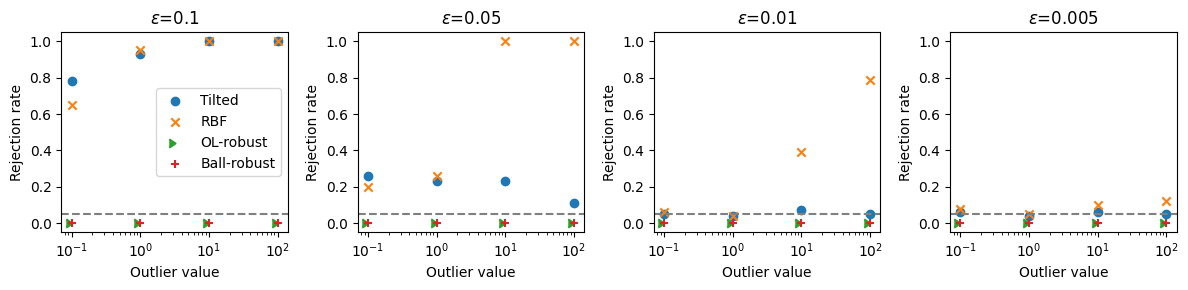

In [118]:
figs, axes = plt.subplots(ncols=len(eps_ls), nrows=1, figsize=(3*len(eps_ls), 3))

# outlier_ls = outlier_ls[::-1]
for j in range(len(eps_ls)):
    ax = axes[j]
    rej_tilted = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted"]["rej"]) for ww in outlier_ls])
    rej_rbf = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["rbf"]["rej"]) for ww in outlier_ls])
    rej_ol_robust = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted_ol_robust"]["rej"]) for ww in outlier_ls])
    rej_ball_robust = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted_ball_robust"]["rej"]) for ww in outlier_ls])

    ax.scatter(outlier_ls, rej_tilted, label="Tilted")
    ax.scatter(outlier_ls, rej_rbf, label="RBF", marker="x")
    ax.scatter(outlier_ls, rej_ol_robust, label="OL-robust", marker=5)
    ax.scatter(outlier_ls, rej_ball_robust, label="Ball-robust", marker="+")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_title(rf"$\epsilon$={eps_ls[j]}")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("Rejection rate")
    ax.set_xlabel("Outlier value")

axes.flatten()[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol.pdf")

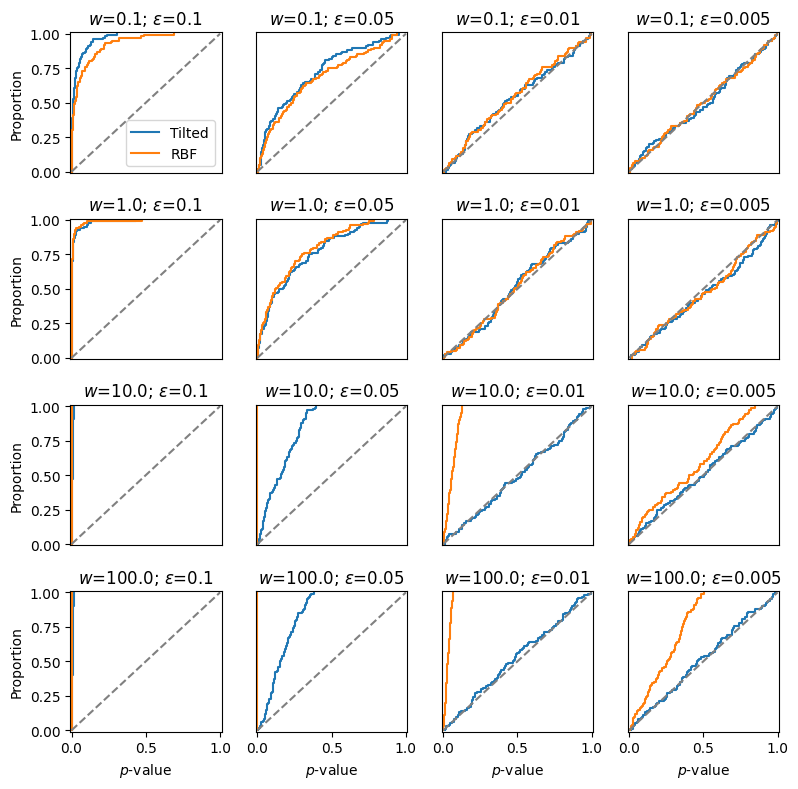

In [45]:
ncols = len(eps_ls)
nrows = len(outlier_ls)
figs, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))

# outlier_ls_plot = outlier_ls[::-1]
for i in range(len(outlier_ls_plot)):
    for j in range(len(eps_ls)):
        ax = axes[i][j]
        sns.ecdfplot(ax=ax, x=np.array(res_ol[outlier_ls_plot[i]][n][eps_ls[j]]["tilted"]["pval"]), label="Tilted")
        sns.ecdfplot(ax=ax, x=np.array(res_ol[outlier_ls_plot[i]][n][eps_ls[j]]["rbf"]["pval"]), label="RBF")
        ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")
        ax.set_xlim(-0.01, 1.01)
        ax.set_ylim(-0.01, 1.01)
        ax.set_title(rf"$w$={outlier_ls_plot[i]}; $\epsilon$={eps_ls[j]}")
        ax.set_ylabel("")
        ax.set_xlabel("")
        
        if i < len(outlier_ls) - 1:
            ax.get_xaxis().set_ticks([])
        if j > 0:
            ax.get_yaxis().set_ticks([])
        if j == 0:
            ax.set_ylabel("Proportion")
        if i == len(outlier_ls) - 1:
            ax.set_xlabel(r"$p$-value")
        # if j == len(eps_ls) - 1:
        #     ax.twinx().set_ylabel(f"eps={eps_ls[j]}")
        #     ax.twinx().get_yaxis().set_ticks([])

axes.flatten()[0].legend(loc="lower right")
plt.tight_layout()

# Level with samples and scores input

In [42]:
np.random.seed(2024)

nreps = 20
n = 500
dim = 1

mean1 = np.zeros((dim,))
mean2 = np.zeros((dim,)) # model

Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))

score_fn = lambda x: - (x - mean2)

scores = score_fn(Xs)

hvps = - scores
hvp_denom_sup = 1.

assert scores.shape == Xs.shape

In [ ]:
res = exp_utils.run_tests(
    samples=Xs, 
    scores=scores,
    hvps=hvps,
    hvp_denom_sup=hvp_denom_sup,
    theta=0.1,
    bw="med",
    verbose=True,
)

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 73/100 [00:59<00:20,  1.29it/s]

0.01
0.03
0.0
0.0


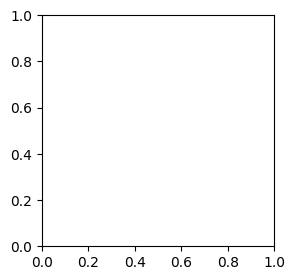

In [46]:
_, ax = plt.subplots(figsize=(3, 3))
methods = ["rbf", "tilted", "tilted_robust_dev", "tilted_robust_clt"]
for m in methods:
    print(np.mean(res[m]["rej"]))

# sns.ecdfplot(ax=ax, x=np.array(res[m]["pval"]))
# ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")

# Outliers vs. kernel bandwidth (level) 

In [41]:
np.random.seed(2024)

n = 500
n_ls = [n]
eps_ls = [0.01]

In [42]:
outlier_ls = [0., 1., 5., 10., 50.]
eps0 = 0.01 # oracle
bandwidth_ls = [1e-2, 1e-1, 1., 10., 100.]

res_ol_bw = {}
for ol in outlier_ls:
    print("outlier:", ol)
    res_ol_bw[ol] = {}
    
    for bw in bandwidth_ls:
        sub_res_ol = rej_rate_outliers(ol, n_ls, eps_ls, eps0=eps0, nreps=100, bandwidth=bw)
        res_ol_bw[ol][bw] = sub_res_ol

outlier: 0.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 1.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 5.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 10.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 50.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

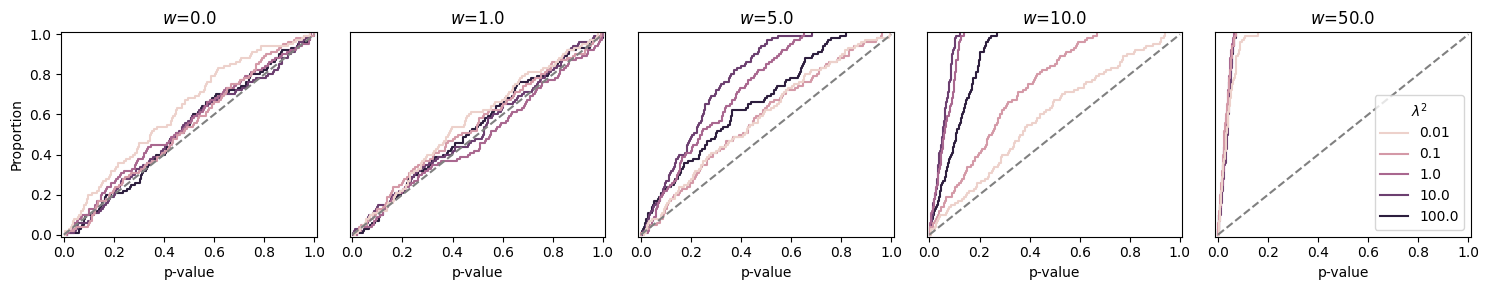

In [76]:
ncols = len(outlier_ls)
figs, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(3*ncols, 3))

method_ls = ["rbf"]

for i, ax in enumerate(axes.flatten()):
    ol = outlier_ls[i]
    
    plot_df = {"pval": [], "method": [], "bw": [], "bw_order": []}
    for bw in bandwidth_ls:
        for mm in method_ls:
            rr = res_ol_bw[ol][bw][n][eps_ls[0]][mm]
            plot_df["pval"] = plot_df["pval"] + np.array(rr["pval"]).tolist()
            plot_df["method"] = plot_df["method"] + [mm] * len(rr["pval"])
            plot_df["bw"] = plot_df["bw"] + [bw] * len(rr["pval"])
            plot_df["bw_order"] = plot_df["bw_order"] + [np.round(np.log(bw) / np.log(10.), 2)] * len(rr["pval"])
    
    plot_df = pd.DataFrame(plot_df)

    # plot
    if_legend = True if i == len(axes)-1 else False
    ax_init = sns.ecdfplot(ax=ax, data=plot_df, x="pval", hue="bw_order", legend=if_legend)
    ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.set_title(rf"$w$={ol}")
    ax.set_xlabel("p-value")
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

sns.move_legend(ax, labels=bandwidth_ls, loc="lower right", title=r"$\lambda^2$")
plt.tight_layout()
# plt.savefig("../figs/robust/standard_power_bw.pdf")

# Mean-shift (power)

In [352]:
def population_ksd_ms(mean, bandwidth_sq=1.):
    """Non-squared KSD"""
    mu = np.reshape([mean], (-1,))
    d = mu.shape[0]
    mu_norm = np.sqrt(np.sum(mu**2))
    return (bandwidth_sq / (bandwidth_sq + 2))**(d/4) * mu_norm

def inverse_population_ksd_ms(val, dim, bandwidth_sq=1.):
    """val is the non-squared KSD"""
    mu_norm = val * (bandwidth_sq / (bandwidth_sq + 2))**(-dim/4)
    return mu_norm

In [353]:
np.random.seed(2024)

n = 500
n_ls = [n]

mean_ls = [0., 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1., 1.2, 1.4]
# mean_ls = [0., 0.1, 0.15, 0.18, 0.2, 0.25]
mean_ls = [np.reshape([mm], (-1,)) for mm in mean_ls]

eps0 = 0.1 # 0.01

In [354]:
res_ms = exp_utils.rej_rate_meanshift(mean_ls=mean_ls, n_ls=n_ls, eps0=eps0, nreps=50) # auto theta selection
# res_ms = exp_utils.rej_rate_meanshift(mean_ls=mean_ls, n_ls=n_ls, theta=0.1, nreps=20)

key: 0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 1


  0%|          | 0/50 [00:00<?, ?it/s]

key: 2


  0%|          | 0/50 [00:00<?, ?it/s]

key: 3


  0%|          | 0/50 [00:00<?, ?it/s]

key: 4


  0%|          | 0/50 [00:00<?, ?it/s]

key: 5


  0%|          | 0/50 [00:00<?, ?it/s]

key: 6


  0%|          | 0/50 [00:00<?, ?it/s]

key: 7


  0%|          | 0/50 [00:00<?, ?it/s]

key: 8


  0%|          | 0/50 [00:00<?, ?it/s]

key: 9


  0%|          | 0/50 [00:00<?, ?it/s]

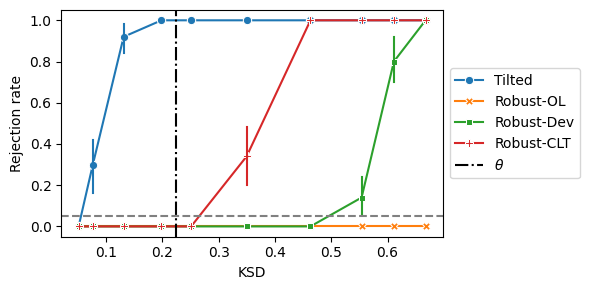

In [359]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

rr = res_ms

methods = {"tilted": "Tilted", "tilted_ol_robust": "Robust-OL", "tilted_robust_dev": "Robust-Dev", "tilted_robust_clt": "Robust-CLT"}

res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
for method, lab in methods.items():
    for kk in range(len(mean_ls)):
        rej = rr[n][kk][method]["rej"]
        res_df["rej"] = res_df["rej"] + rej
        res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
        res_df["method"] = res_df["method"] + [lab] * len(rej)
        mean_ksd = np.mean(rr[n][kk][method]["stat"])**0.5
        res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
res_df = pd.DataFrame(res_df)

sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

theta = rr[n][i]["tilted_robust_dev"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

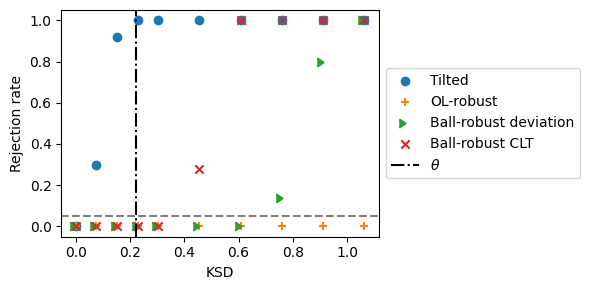

In [205]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in range(len(mean_ls))])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in range(len(mean_ls))])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in range(len(mean_ls))])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
# # ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker="x") #, marker=6)
theta = res_ms[n][0]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

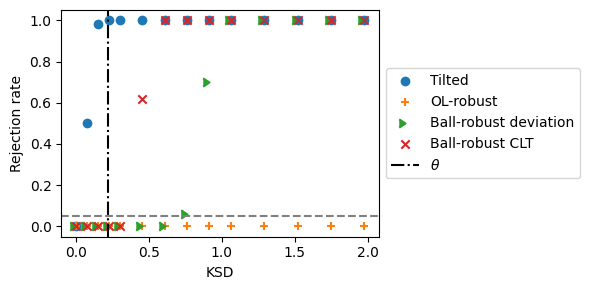

In [170]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in range(len(mean_ls))])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in range(len(mean_ls))])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in range(len(mean_ls))])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
# # ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker="x") #, marker=6)
theta = res_ms[n][0]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

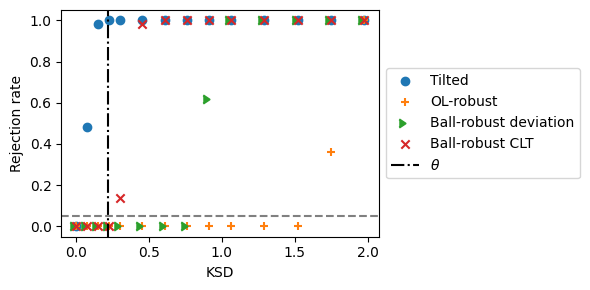

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in range(len(mean_ls))])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in range(len(mean_ls))])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in range(len(mean_ls))])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
# ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker="x") #, marker=6)
theta = res_ms[n][0]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

#### Power vs. dim

In [431]:
path = "res/robust/ms"
dim_ls = [1, 5, 10, 20, 50, 100]
n = 500

res_ms_dim = {}
for d in dim_ls:
    rr = pickle.load(open("../" + path + f"/ms_n{n}_d{d}.pkl", "rb"))
    res_ms_dim[d] = rr

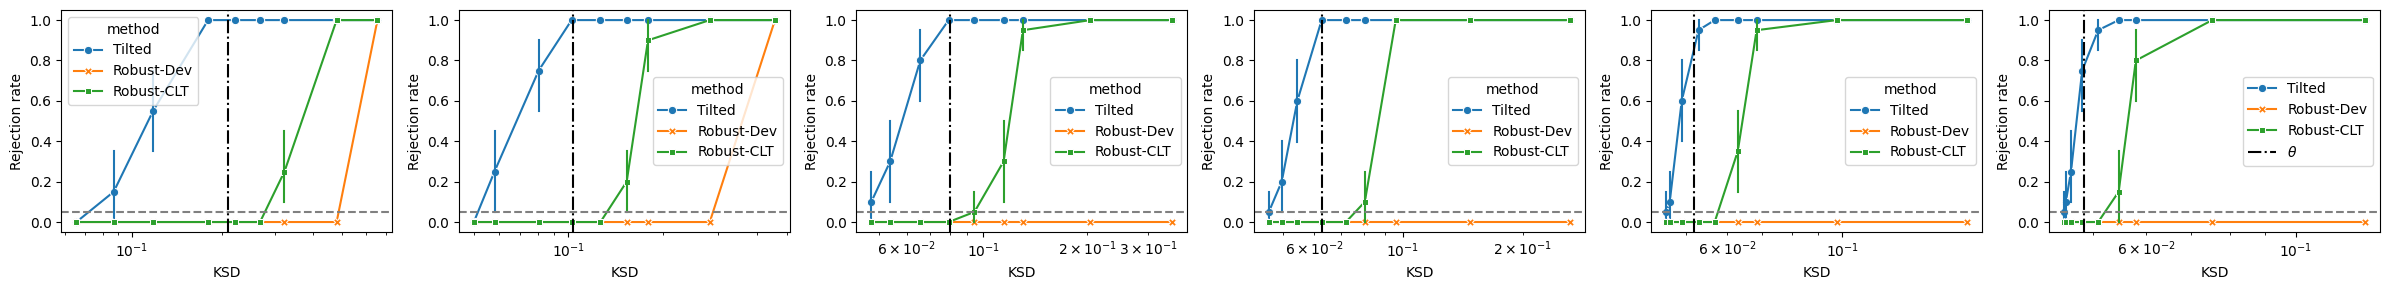

In [432]:
_, axes = plt.subplots(ncols=len(dim_ls), nrows=1, figsize=(4*len(dim_ls), 3))
axes = [axes] if len(dim_ls) == 1 else axes

methods = {"tilted": "Tilted", "tilted_robust_dev": "Robust-Dev", "tilted_robust_clt": "Robust-CLT"}

for i, ax in enumerate(axes):
    dim = dim_ls[i]
    rr = res_ms_dim[dim]

    mean_ls = [np.ones((dim,)) * ss for ss in mean_scale_ls]
    ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
    
    res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
    for method, lab in methods.items():
        for kk in range(len(mean_ls)):
            rej = rr[n][kk][method]["rej"]
            res_df["rej"] = res_df["rej"] + rej
            res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
            res_df["method"] = res_df["method"] + [lab] * len(rej)
            mean_ksd = np.mean(rr[n][kk][method]["stat"])**0.5
            res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
    res_df = pd.DataFrame(res_df)

    sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

    theta = rr[n][i]["tilted_robust_dev"]["theta"][0]
    ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("KSD")
    ax.set_ylabel("Rejection rate")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

In [429]:
# theta = 0.1
for d in dim_ls:
    res_ms_dim[d] = exp_utils.change_theta(res_ms_dim[d], methods=["tilted_robust_dev", "tilted_robust_clt"], theta=theta)

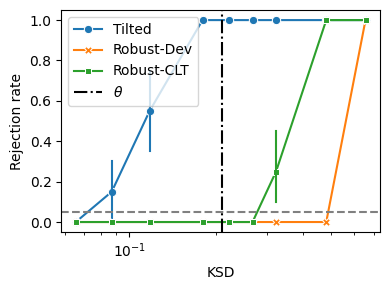

In [430]:
_, axes = plt.subplots(ncols=len(dim_ls), nrows=1, figsize=(4*len(dim_ls), 3))
axes = [axes] if len(dim_ls) == 1 else axes

methods = {"tilted": "Tilted", "tilted_robust_dev": "Robust-Dev", "tilted_robust_clt": "Robust-CLT"}

for i, ax in enumerate(axes):
    dim = dim_ls[i]
    rr = res_ms_dim[dim]

    mean_ls = [np.ones((dim,)) * ss for ss in mean_scale_ls]
    ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
    
    res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
    for method, lab in methods.items():
        for kk in range(len(mean_ls)):
            rej = rr[n][kk][method]["rej"]
            res_df["rej"] = res_df["rej"] + rej
            res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
            res_df["method"] = res_df["method"] + [lab] * len(rej)
            mean_ksd = np.mean(rr[n][kk][method]["stat"])**0.5
            res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
    res_df = pd.DataFrame(res_df)

    sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

    theta = rr[n][i]["tilted_robust_dev"]["theta"][0]
    ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("KSD")
    ax.set_ylabel("Rejection rate")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

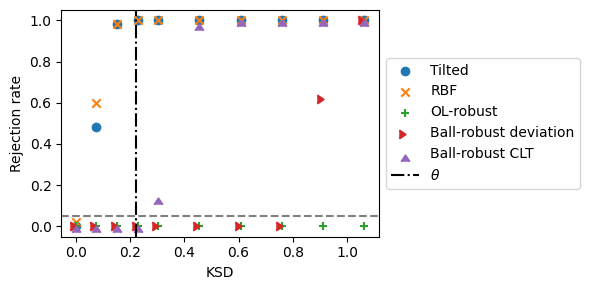

In [295]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in mean_ls])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in mean_ls])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in mean_ls])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in mean_ls])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in mean_ls])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in mean_ls])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in mean_ls])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker=6)
theta = res_ms[n][mean_ls[0]]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

key: 0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


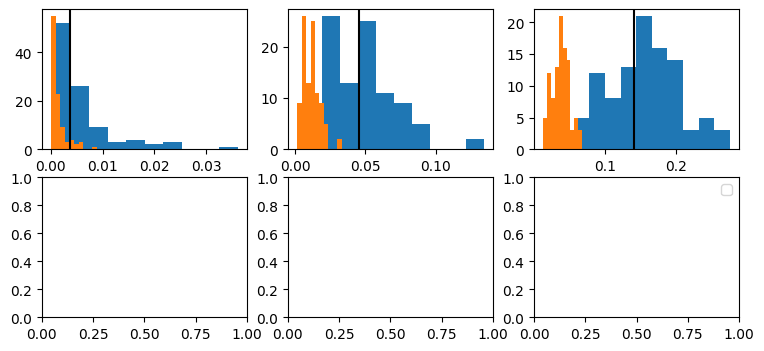

In [171]:
def check_jackknife(mean_ls, n, nreps, dim=1, alpha=0.05):
    res = {kk: {
        "jackknife": [],
        "standard": [],
        "oracle": [],
    } for kk in range(len(mean_ls))}
    res["mean_ls"] = mean_ls
    
    for i, mean in enumerate(mean_ls):
        key = i
        print("key:", key)
        ###
        mean1 = np.zeros((dim,)) # data
        mean2 = np.reshape([mean], (-1,)) # model
        
        Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
    
        score_fn = lambda x: - (x - mean2)
        ###
        
        for X in tqdm(Xs):
            # tilted ball robust CLT
            score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
            ksd = metrics.KSD(kernel, score_fn=score_fn)

            # 1
            res[key]["jackknife"].append(ksd.jackknife(X, X))

            # 2
            u_mat = ksd(X, X, output_dim=2, vstat=True) # n x n
            witness = np.sum(u_mat, axis=1) / n # n
            term1 = np.sum(witness**2) / n
            term2 = (np.mean(u_mat))**2
            res[key]["standard"].append(term1 - term2 + 1e-12)

        # 3. oracle
        # X_ora = np.random.multivariate_normal(mean1, np.eye(dim), (5000,))
        # mm = np.mean(u_mat)
        # res[key]["oracle"] = np.mean((np.sum(u_mat, -1) / n- mm)**2)
        
        Xs_ora = np.random.multivariate_normal(mean1, np.eye(dim), (100, n))
        ksd_val_ls = []
        for X in tqdm(Xs_ora):
            score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
            ksd = metrics.KSD(kernel, score_fn=score_fn)
            ksd_val = ksd(X, X)
            ksd_val_ls.append(ksd_val)
        
        res[key]["oracle"] = np.var(np.sqrt(n) * (ksd_val_ls - np.mean(ksd_val_ls)))
            
    return res


np.random.seed(2024)
mean_ls = [0., 0.2, 0.4]
mean_ls = [np.reshape([mm], (-1,)) for mm in mean_ls]
var_res = check_jackknife(mean_ls=mean_ls, n=n, nreps=100)

_, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 4))
for i in range(len(mean_ls)):
    ax = axes.flatten()[i]
    _ = ax.hist(var_res[i]["jackknife"], label="jackknife")
    _ = ax.hist(var_res[i]["standard"], label="standard")
    ax.axvline(var_res[i]["oracle"], color="k", label="oracle")

plt.legend()

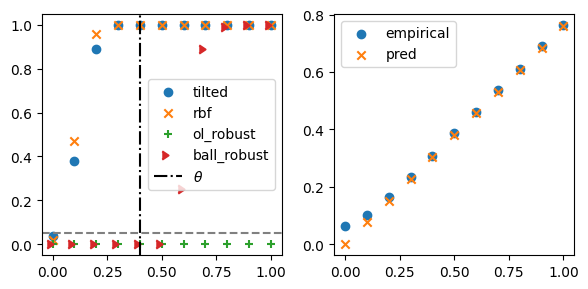

In [111]:
figs, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))

ax = axes[0]
rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in mean_ls])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in mean_ls])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in mean_ls])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in mean_ls])

ax.scatter(mean_ls, rej_tilted, label="tilted")
ax.scatter(mean_ls, rej_rbf, label="rbf", marker="x")
ax.scatter(mean_ls, rej_ol_robust, label="ol_robust", marker="+")
ax.scatter(mean_ls, rej_ball_robust, label="ball_robust", marker=5)
theta = res_ms[n][mean_ls[0]]["tilted_ball_robust"]["threshold"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.legend()

ax = axes[1]
ksd_val = [np.mean(res_ms[n][kk]["rbf"]["stat"])**0.5 for kk in mean_ls]
ksd_val_pred = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(mean_ls, ksd_val, label="empirical")
ax.scatter(mean_ls, ksd_val_pred, marker="x", label="pred")
# ax.set_xscale("log")
ax.legend()

plt.tight_layout()

# Test using pre-computed stats

In [152]:
SAVE_DIR = "../data/ms"
n = 500
dim = 1

X_res = pickle.load(open(f"{SAVE_DIR}/ms_X_res_n{n}_d{dim}.pkl", "rb"))
score_res = pickle.load(open(f"{SAVE_DIR}/ms_score_res_n{n}_d{dim}.pkl", "rb"))
hpv_res = pickle.load(open(f"{SAVE_DIR}/ms_hvp_res_n{n}_d{dim}.pkl", "rb"))
stats_res = pickle.load(open(f"{SAVE_DIR}/ms_stats_n{n}_d{dim}.pkl", "rb"))

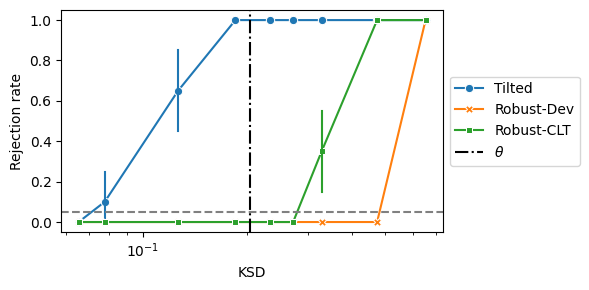

In [154]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

rr = stats_res
mean_ls = list(rr.keys())

methods = {"tilted": "Tilted", "tilted_robust_dev": "Robust-Dev", "tilted_robust_clt": "Robust-CLT"}

res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
for method, lab in methods.items():
    for kk, ss in enumerate(mean_ls):
        rej = rr[ss][method]["rej"]
        res_df["rej"] = res_df["rej"] + rej
        res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
        res_df["method"] = res_df["method"] + [lab] * len(rej)
        mean_ksd = np.abs(np.mean(rr[ss][method]["u_stat"]))**0.5
        res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
res_df = pd.DataFrame(res_df)

sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

theta = rr[mean_ls[0]]["tilted_robust_dev"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

In [137]:
# change theta
theta_new = .3

stats_res_new = copy.deepcopy(stats_res)
for ss in mean_ls:
    stats_res_new[ss] = exp_utils.change_theta(stats_res_new[ss], ["tilted_robust_dev", "tilted_robust_clt"], theta_new)

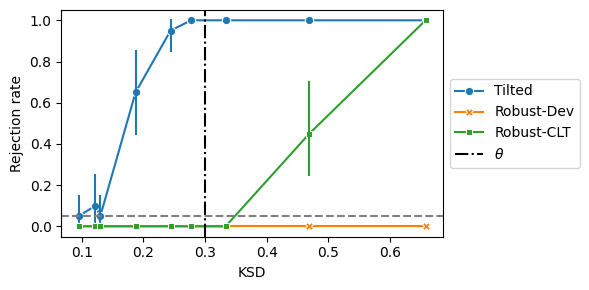

In [134]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

rr = stats_res_new
mean_ls = list(rr.keys())

methods = {"tilted": "Tilted", "tilted_robust_dev": "Robust-Dev", "tilted_robust_clt": "Robust-CLT"}

res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
for method, lab in methods.items():
    for kk, ss in enumerate(mean_ls):
        rej = rr[ss][method]["rej"]
        res_df["rej"] = res_df["rej"] + rej
        res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
        res_df["method"] = res_df["method"] + [lab] * len(rej)
        mean_ksd = np.mean(rr[ss][method]["stat"])**0.5
        res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
res_df = pd.DataFrame(res_df)

sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

theta = rr[mean_ls[0]]["tilted_robust_dev"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")